In [1]:
from pymongo import MongoClient
import pymongo
from bson.son import SON
import json
import pprint
import pylab as plt
import numpy as np
from collections import namedtuple
# from tabulate import tabulate
import datetime
from itertools import groupby, filterfalse
import scipy.io as sio
import pandas as pd
import xarray as xr
import re
from scipy.interpolate import interp1d
from scipy import integrate
from pyorbital import astronomy
from pyproj import Transformer, transform
from glob import glob
import coastval_spectrum

plt.rcParams['figure.facecolor'] = 'white'

pp = pprint.PrettyPrinter(width=41, compact=True)

The remote sensing reflectance, $R_{rs}$, is an example of radiometric parameter that will be provided from inversion of the data collected by the in situ validation platform sensors. It is also related to the water leaving radiance, $L_w$, and the water-leaving radiance reflectance or directional reflectance, $ρ_w$ by the simple relationships as shown below: 


$R_{rs} = \frac{Lw}{E_d^{0+}} = \frac{\rho_w}{\pi}$

where $E_d^{0+}$ is the downwelling irradiance measured in air and $L_w$ is the water-leaving radiance just above the water in the upward direction measured by the satellite sensors whose observation position is defined by the zenith angle θ and azimuth φ, that is, 

$L_w(λ, θ, φ)$.

The water-leaving radiance is the component of the air-water interface, which is equal to the measured above water directional upwelling radiance, L0+u, after removal of the downward sky/sun radiance, Lr, reflected at the air-water interface. (Lr may contain sky glint as well as specularly reflected sunlight) and is given by

$L_w= L_0 + u − L_r$

Also, the upwelling radiance at nadir just below the water surface is given by, 

$L_{un}(0−) = L_{un}(z_1) exp[KL_{u(z_1)}]$

where $Lun(z1)$ is the upwelling radiance measured at depth  $z1$
, and 
$K_{Lu}$
, the diffuse attenuation coefficient for upwelling radiance is given by, 

$K_{Lu}= 1z1−z2[Lun(z1)Lun(z2)]$
 

Where 
$Lun(z1)$
 and 
$Lun(z2)$
 are measured simultaneously by the two radiance sensors position at different depths.    

From this measure of the upwelling radiance at nadir just below the surface, the nadir water-leaving radiance above the surface can be derived according to, 
$Lwn= TFnw2Lun(0−)$
where $TF$ is the Fresnel transmittance of radiance from water to air and $ηw$ is the refractive index of water.    

Therefore, can be written as, 
$Lwn = TFnw2$
$Lun(z1)exp{[1z1−z2[Lun(z1)Lun(z2)]].z1}$
 
From this equation it can be seen that the uncertainty in the determination of the nadir water leaving radiance is dependent on the uncertainty in the upwelling radiance measurements at two depths, as well as the uncertainty in the measurements of those depths. It is also dependent on the value of $TFηw2$, which has a value of 0.543 (to within 1% under most conditions). 

(Of course, the diffuse coefficient, $KEd$, that is derived from the CoastVal downwelling in-water irradiance sensors, 
Ed(z1)
 and 
Ed(z2)
 may also be used as an approximation of 
KLu
 to extrapolate 
Lun(z1)
 to 
Lun(0−)
. ) 

Although the satellite views the ocean at an oblique angle, its detection of water-leaving radiance is corrected to a nadir viewing position. 

False


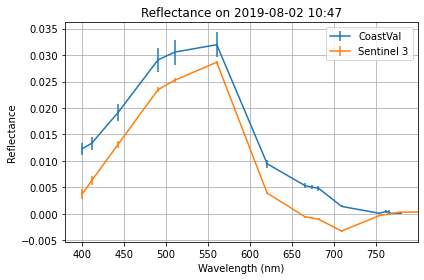

0
True
False


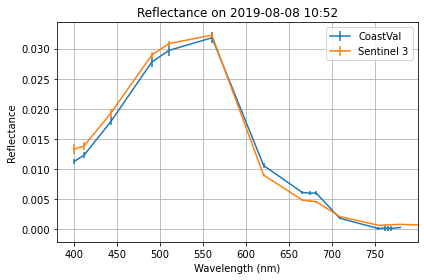

1
False


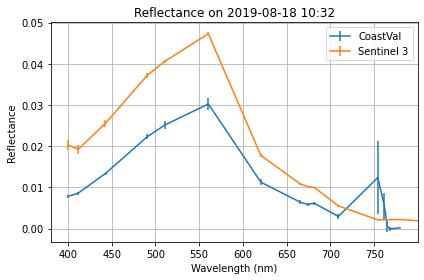

2
False


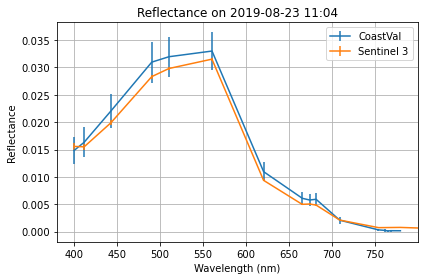

3
False


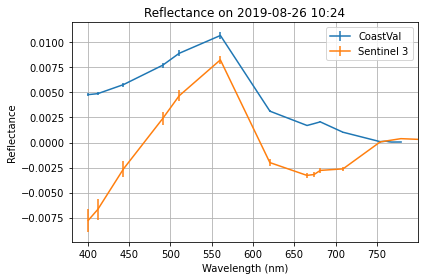

4
False


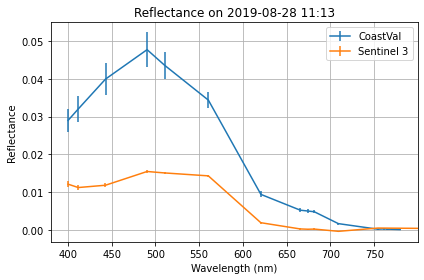

5
False


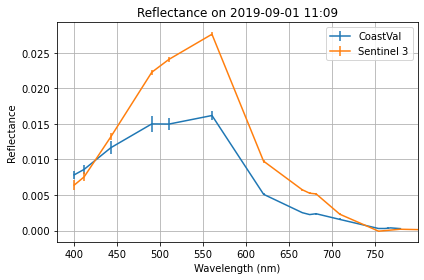

6
False
True
False


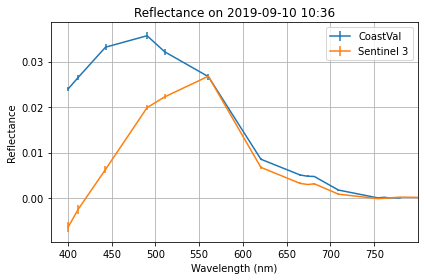

7
True


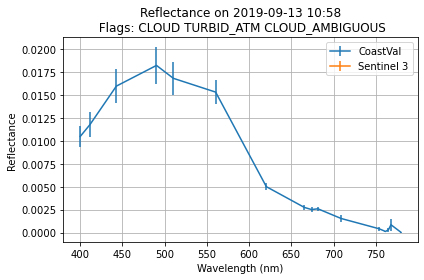

8
False


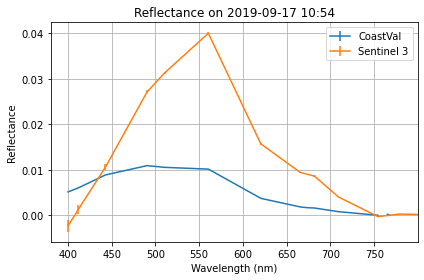

9
False


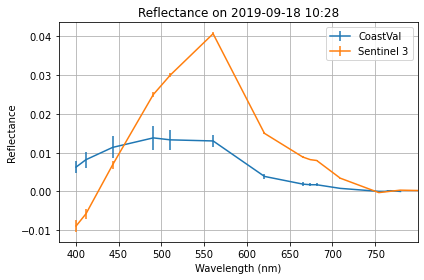

10
False


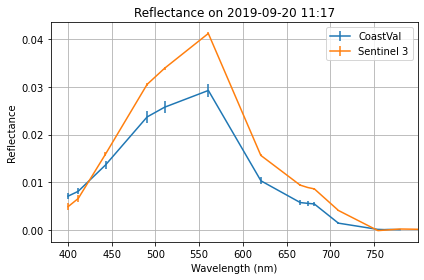

11
False


In [2]:
import warnings
warnings.filterwarnings("ignore")
# Sentinel 3

num_s3_pixels = 9

def flags(ds):
    global pixel
    meanings = ds['wqsf'].flag_meanings.split(' ')
    for pixel in ds['wqsf']:
        for i, m in enumerate(pixel.flag_masks):
            if m % pixel.values == 0:
                yield meanings[i]
times = []
coeff_of_variations = []
ii = 0
for i, zarr_name in enumerate(sorted(glob('/data/sentinel3/reprocessed/SL_2_WST_reprocessed_20201030_nearestneighbors/*'), key=lambda fn: re.match('.*____(\d{8}T\d{6})_.*', fn).group(1))):
    try:
        ds = xr.open_zarr(zarr_name)
        ds_z = ds.isel(time=0).stack(z=['x', 'y']).sortby('distance')
        print(np.all(np.isnan(ds_z['reflectivity'].values)))
        t_start = datetime.datetime.strptime(ds_z.start_time, '%Y-%m-%dT%H:%M:%S.%fZ')
        t_end = datetime.datetime.strptime(ds_z.stop_time, '%Y-%m-%dT%H:%M:%S.%fZ')

        specs = coastval_spectrum.compute_spectra(t_start, t_end)
        Rrs = specs['Rrs']
        ds_z = ds_z.isel(z=slice(0, num_s3_pixels))
        
        plt.errorbar(Rrs.columns, Rrs.mean(), Rrs.std())
        ref = ds_z['reflectivity']
        ref_err = ds_z['reflectivity_err']
        plt.errorbar(ref.wavelength, ref.mean(dim='z'), ref_err.mean(dim='z'))
        wavelengths = list(Rrs.columns)
        plt.xlim(wavelengths[0] - 20, wavelengths[-1] + 20)
        plt.legend(['CoastVal', 'Sentinel 3'])
        title = f'Reflectance on {str(t_start)[:16]}'
        flag_list = list(flags(ds_z))[:3]
        if flag_list:
            title += '\n Flags: ' + ' '.join(flag_list)
        if not flag_list:
            times.append(ds.time[0].values)
            ref_band6 = ds_z.reflectivity.isel(band=5)
            coeff_of_variations.append((ref_band6.std(dim='z')/ref_band6.mean(dim='z')).values)
        plt.title(title)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Reflectance')
        plt.grid()
        plt.tight_layout()
        plt.savefig(zarr_name.replace('.zarr', '.png'), dpi=180)
        plt.show()
        print(ii)
        ii += 1
    except (KeyError, ValueError):
        pass

In [3]:
ds_z.solar_azimuth_angle.isel(z=0).values

array(154.24601132)

In [4]:
ds_zss = []
Rrss = []
for zarr_name in sorted(glob('/data/sentinel3/reprocessed/SL_2_WST_reprocessed_20201030_nearestneighbors/*'), key=lambda fn: re.match('.*____(\d{8}T\d{6})_.*', fn).group(1)):
    try:
        ds = xr.open_zarr(zarr_name)
        ds_z = ds.isel(time=0).stack(z=['x', 'y']).sortby('distance')
        print(np.all(np.isnan(ds_z['reflectivity'].values)))
        t_start = datetime.datetime.strptime(ds_z.start_time, '%Y-%m-%dT%H:%M:%S.%fZ')
        t_end = datetime.datetime.strptime(ds_z.stop_time, '%Y-%m-%dT%H:%M:%S.%fZ')

        specs = coastval_spectrum.compute_spectra(t_start, t_end)
        Rrs = specs['Rrs']
        
        ds_z = ds_z.isel(z=slice(0, num_s3_pixels))
        
        ds_z = ds_z.expand_dims('time')
        ds_z['time'] = ds.time
        ds_z['Rrs'] = xr.DataArray(Rrs, dims=('times', 'band')) 
        ds_zss.append(ds_z)
#         Rrss.append(Rrs)
    except (KeyError, ValueError):
        pass
    
ds_zs =  xr.concat(ds_zss, dim='time')
ds_zs['Rrs_mean'] = ds_zs['Rrs'].mean(dim='times', skipna=True)

False
True
False
False
False
False
False
False
False
True
False
True
False
False
False
False


In [116]:
ds_mean = ds_zs.mean(dim='z')
ds_mean

<xarray.Dataset>
Dimensions:                  (band: 16, time: 12, times: 260)
Coordinates:
  * times                    (times) datetime64[ns] 2019-08-02T10:47:31.29000...
  * band                     (band) object 400.2 411.8 443.0 ... 768.0 779.5
  * time                     (time) datetime64[ns] 2019-08-02T10:47:28.063948...
    wavelength               (band) float64 400.3 411.8 ... 884.3 1.016e+03
Data variables:
    altitude                 (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    chl_nn                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    chl_oc4me                (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    iop_nn                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mask                     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    reflectivity             (time, band) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    reflectivity_err         (time, band) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    reflectivity_satpy       (time, band) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    satellite_azimuth_angle  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    satellite_zenith_angle   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    solar_azimuth_angle      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    solar_zenith_angle       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    trsp                     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tsm_nn                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wqsf                     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Rrs                      (time, times, band) float64 0.01168 ... 6.893e-05
    Rrs_mean                 (time, band) float64 0.01227 0.01334 ... 5.042e-05

In [111]:
ds_mean.to_netcdf('/home/john/code/coastval_data_analysis/data/coastval_olic_reflectivity.nc')

In [5]:
ds_zs

<xarray.Dataset>
Dimensions:                  (band: 16, time: 12, times: 260, z: 28)
Coordinates:
  * times                    (times) datetime64[ns] 2019-08-02T10:47:31.29000...
  * z                        (z) MultiIndex
  - z_level_0                (z) int64 13 14 14 14 14 15 ... 18 18 18 19 19 19
  - z_level_1                (z) int64 21 19 20 21 22 18 ... 20 21 22 20 21 22
  * band                     (band) object 400.2 411.8 443.0 ... 768.0 779.5
    distance                 (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    lat                      (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    latitude                 (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    lon                      (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    longitude                (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2019-08-02T10:47:28.063948...
    wavelength               (band) float64 400.3 411.8 ... 884.3 1.016e+03
    xx                       (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    yy                       (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
Data variables:
    altitude                 (time, z) float32 dask.array<chunksize=(1, 28), meta=np.ndarray>
    chl_nn                   (time, z) float32 dask.array<chunksize=(1, 28), meta=np.ndarray>
    chl_oc4me                (time, z) float32 dask.array<chunksize=(1, 28), meta=np.ndarray>
    iop_nn                   (time, z) float32 dask.array<chunksize=(1, 28), meta=np.ndarray>
    mask                     (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    reflectivity             (time, band, z) float32 dask.array<chunksize=(1, 1, 28), meta=np.ndarray>
    reflectivity_err         (time, band, z) float32 dask.array<chunksize=(1, 1, 28), meta=np.ndarray>
    reflectivity_satpy       (time, band, z) float32 dask.array<chunksize=(1, 1, 28), meta=np.ndarray>
    satellite_azimuth_angle  (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    satellite_zenith_angle   (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    solar_azimuth_angle      (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    solar_zenith_angle       (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    trsp                     (time, z) float32 dask.array<chunksize=(1, 28), meta=np.ndarray>
    tsm_nn                   (time, z) float32 dask.array<chunksize=(1, 28), meta=np.ndarray>
    wqsf                     (time, z) float64 dask.array<chunksize=(1, 28), meta=np.ndarray>
    Rrs                      (time, times, band) float64 0.01168 ... 6.893e-05
    Rrs_mean                 (time, band) float64 0.01227 0.01334 ... 5.042e-05
Attributes:
    absolute_orbit_number:  18005
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2020-10-27T13:27:38Z
    history:                 
    institution:            MAR
    netCDF_version:         4.3.3.1 of Dec 10 2015 16:44:18 $
    product_name:           S3A_OL_2_WFR____20190802T104728_20190802T105028_2...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.00
    start_time:             2019-08-02T10:47:28.063948Z
    stop_time:              2019-08-02T10:50:28.063948Z
    title:                  OLCI Level 2 WATER Product, Reflectance Oa02 Data...

In [106]:
dd = (ds_mean['reflectivity'] - ds_mean['Rrs_mean'])

In [107]:
for d in dd:
    plt.plot(d.wavelengths, d.values, c='k')
plt.xlim(dd.wavelength.isel(band=0), 800)

AttributeError: 'DataArray' object has no attribute 'wavelengths'

In [101]:
dd.wavelength.isel(band=0)

<xarray.DataArray 'wavelength' ()>
array(400.30316162)
Coordinates:
    band        float64 400.2
    wavelength  float64 400.3

NameError: name 'ptl' is not defined

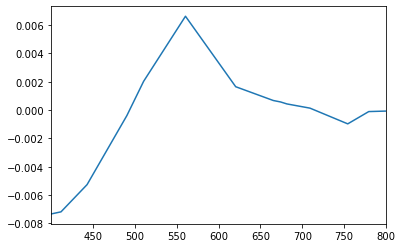

In [104]:
plt.plot(dd.wavelength, dd.mean(dim='time').values)
plt.xlim(dd.wavelength.isel(band=0), 800)
ptl.grid()

In [97]:
dd = ds_zs.groupby('time').mean(dim='times').isel(z=slice(0, 9))#.dropna(dim='time', how='all')
# dd['reflectivity'].isel(time=2).values

In [101]:
dd[['reflectivity', 'reflectivity_err', 'reflectivity_satpy', 'Rrs']]

<xarray.Dataset>
Dimensions:             (band: 16, time: 12, z: 9)
Coordinates:
  * z                   (z) MultiIndex
  - z_level_0           (z) int64 12 12 12 12 13 13 13 13 13
  - z_level_1           (z) int64 18 19 20 21 18 19 20 21 22
  * band                (band) object 400.2 411.8 443.0 ... 765.0 768.0 779.5
    distance            (time, z) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    lat                 (time, z) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    latitude            (time, z) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    lon                 (time, z) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    longitude           (time, z) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
  * time                (time) datetime64[ns] 2019-08-02T10:47:28.063948 ... ...
    wavelength          (band) float64 400.3 411.8 443.0 ... 884.3 1.016e+03
    xx                  (time, z) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    yy                  (time, z) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
Data variables:
    reflectivity        (time, band, z) float32 dask.array<chunksize=(1, 1, 9), meta=np.ndarray>
    reflectivity_err    (time, band, z) float32 dask.array<chunksize=(1, 1, 9), meta=np.ndarray>
    reflectivity_satpy  (time, band, z) float32 dask.array<chunksize=(1, 1, 9), meta=np.ndarray>
    Rrs                 (time, band) float64 0.01227 0.01334 ... 5.042e-05

In [ ]:
for i, ds_z in ds_zs.groupby('time'):
    try:
        ds_z = ds_z.isel(z=slice(0, num_s3_pixels))
        ref = ds_z['reflectivity']
        ref_err = ds_z['reflectivity_err']
        if np.isnan(ds_z['Rrs'].mean(dim='times')).all():
            raise ValueError
        
        plt.errorbar(ref.wavelength, ds_z['Rrs'].mean(dim='times'), ds_z['Rrs'].std(dim='times'))
        wavelengths = list(Rrs.columns)
        
        ref = ds_z['reflectivity_satpy'].isel(z=slice(0, 9))
        
        if np.isnan(ref.mean(dim='z')).all():
            raise ValueError
            
        ref_err = ds_z['reflectivity_err'].isel(z=slice(0, 9))
        plt.errorbar(ref.wavelength, ref.mean(dim='z'), ref_err.mean(dim='z'))
#         break

        plt.xlim(wavelengths[0] - 20, wavelengths[-1] + 20)
        plt.legend(['CoastVal', 'Sentinel 3'])
        title = f'Reflectance on {str(t_start)[:16]}'
        flag_list = list(flags(ds_z))[:3]
        if flag_list:
            title += '\n Flags: ' + ' '.join(flag_list)
#         if not flag_list:
#             times.append(ds.time[0].values)
#             ref_band6 = ds_z.reflectivity.isel(band=5)
#             coeff_of_variations.append((ds_z.reflectivity_err / ds_z.reflectivity_err).values)
        plt.title(title)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Reflectance')
        plt.grid()
        plt.tight_layout()
        plt.savefig(zarr_name.replace('.zarr', '.png'), dpi=180)
        plt.show()
        print(ii)
#         ii += 1    
    except (KeyError, ValueError):
        plt.clf()

In [21]:
ds_zs

<xarray.Dataset>
Dimensions:                  (band: 16, time: 12, times: 260, z: 59)
Coordinates:
  * times                    (times) datetime64[ns] 2019-08-02T10:47:31.29000...
  * z                        (z) MultiIndex
  - z_level_0                (z) int64 12 12 12 12 13 13 ... 19 20 20 20 20 20
  - z_level_1                (z) int64 18 19 20 21 18 19 ... 24 20 21 22 23 24
  * band                     (band) object 400.2 411.8 443.0 ... 768.0 779.5
    distance                 (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    lat                      (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    latitude                 (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    lon                      (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    longitude                (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2019-08-02T10:47:28.063948...
    wavelength               (band) float64 400.3 411.8 ... 884.3 1.016e+03
    xx                       (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    yy                       (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
Data variables:
    altitude                 (time, z) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    chl_nn                   (time, z) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    chl_oc4me                (time, z) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    iop_nn                   (time, z) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    mask                     (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    reflectivity             (time, band, z) float32 dask.array<chunksize=(1, 1, 59), meta=np.ndarray>
    reflectivity_err         (time, band, z) float32 dask.array<chunksize=(1, 1, 59), meta=np.ndarray>
    reflectivity_satpy       (time, band, z) float32 dask.array<chunksize=(1, 1, 59), meta=np.ndarray>
    satellite_azimuth_angle  (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    satellite_zenith_angle   (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    solar_azimuth_angle      (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    solar_zenith_angle       (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    trsp                     (time, z) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    tsm_nn                   (time, z) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    wqsf                     (time, z) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    Rrs                      (time, times, band) float64 0.01168 ... 6.893e-05
    Rrs_mean                 (time, band) float64 0.01227 0.01334 ... 5.042e-05
Attributes:
    absolute_orbit_number:  18005
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2020-10-27T13:27:38Z
    history:                 
    institution:            MAR
    netCDF_version:         4.3.3.1 of Dec 10 2015 16:44:18 $
    product_name:           S3A_OL_2_WFR____20190802T104728_20190802T105028_2...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.00
    start_time:             2019-08-02T10:47:28.063948Z
    stop_time:              2019-08-02T10:50:28.063948Z
    title:                  OLCI Level 2 WATER Product, Reflectance Oa02 Data...

In [25]:
d = ds_zs.isel(z=0)
(d['Rrs'] - d['reflectivity_satpy'].isel(band=0)).mean(dim='time').values#.plot()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [30]:
d

<xarray.Dataset>
Dimensions:                  (band: 16, time: 12, times: 260)
Coordinates:
  * times                    (times) datetime64[ns] 2019-08-02T10:47:31.29000...
    z                        object (12, 18)
  * band                     (band) object 400.2 411.8 443.0 ... 768.0 779.5
    distance                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lat                      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lon                      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude                (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2019-08-02T10:47:28.063948...
    wavelength               (band) float64 400.3 411.8 ... 884.3 1.016e+03
    xx                       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    yy                       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    altitude                 (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    chl_nn                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    chl_oc4me                (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    iop_nn                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mask                     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    reflectivity             (time, band) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    reflectivity_err         (time, band) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    reflectivity_satpy       (time, band) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    satellite_azimuth_angle  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    satellite_zenith_angle   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    solar_azimuth_angle      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    solar_zenith_angle       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    trsp                     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tsm_nn                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    wqsf                     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Rrs                      (time, times, band) float64 0.01168 ... 6.893e-05
    Rrs_mean                 (time, band) float64 0.01227 0.01334 ... 5.042e-05
Attributes:
    absolute_orbit_number:  18005
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2020-10-27T13:27:38Z
    history:                 
    institution:            MAR
    netCDF_version:         4.3.3.1 of Dec 10 2015 16:44:18 $
    product_name:           S3A_OL_2_WFR____20190802T104728_20190802T105028_2...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.00
    start_time:             2019-08-02T10:47:28.063948Z
    stop_time:              2019-08-02T10:50:28.063948Z
    title:                  OLCI Level 2 WATER Product, Reflectance Oa02 Data...

In [43]:
d['Rrs_mean']

<xarray.DataArray 'Rrs_mean' (time: 12, band: 16)>
array([[ 1.22683533e-02,  1.33394381e-02,  1.91472194e-02,
         2.90849345e-02,  3.05729944e-02,  3.19660209e-02,
         9.43778460e-03,  5.31672988e-03,  5.01459303e-03,
         4.83139626e-03,  1.38497755e-03,  7.83909296e-05,
         4.14999203e-04,  2.87449409e-04,  5.05281902e-05,
         8.51403449e-05],
       [ 1.12574188e-02,  1.22830817e-02,  1.79084018e-02,
         2.77721418e-02,  2.97142901e-02,  3.18085587e-02,
         1.05801803e-02,  6.09731227e-03,  5.98754162e-03,
         6.01337967e-03,  1.81660739e-03,  9.68240678e-05,
         1.90621732e-04,  1.61828932e-04,  1.17560059e-04,
         2.86556962e-04],
       [ 7.82178518e-03,  8.60016833e-03,  1.33994972e-02,
         2.22719326e-02,  2.51180737e-02,  3.02568498e-02,
         1.12684536e-02,  6.41469407e-03,  5.89317166e-03,
         6.15598748e-03,  2.95933891e-03,  1.23948506e-02,
         5.55330203e-03,  5.53308300e-04, -8.01407142e-05,
         1.85953306e-04],
       [ 1.48432365e-02,  1.63128236e-02,  2.20467376e-02,
         3.09710704e-02,  3.19576001e-02,  3.29932524e-02,
...
         1.22633682e-04,  3.09766842e-04,  8.57462210e-04,
         5.23513209e-05],
       [ 5.14850713e-03,  6.02232202e-03,  8.88122340e-03,
         1.09243589e-02,  1.05449808e-02,  1.01539100e-02,
         3.73547605e-03,  1.85070725e-03,  1.68129885e-03,
         1.61943224e-03,  8.16142813e-04,  2.77580466e-05,
                    nan,  2.35552569e-04,  1.03216221e-05,
                    nan],
       [ 6.28321209e-03,  8.19333812e-03,  1.13715368e-02,
         1.38274898e-02,  1.33188566e-02,  1.30355230e-02,
         3.88338286e-03,  1.89495983e-03,  1.73832243e-03,
         1.73593772e-03,  8.00909072e-04,  3.58567592e-05,
         2.59069051e-05,  1.62790777e-04,  1.94162396e-04,
         8.20460015e-06],
       [ 7.07602434e-03,  8.07960892e-03,  1.36104135e-02,
         2.36808894e-02,  2.57243140e-02,  2.92357388e-02,
         1.02965956e-02,  5.72803034e-03,  5.56372980e-03,
         5.43737219e-03,  1.41248876e-03,  1.04123241e-04,
         5.97597526e-05,  8.38023739e-05,  9.23650902e-05,
         5.04223288e-05]])
Coordinates:
    z           object (12, 18)
  * band        (band) object 400.2 411.8 443.0 490.5 ... 765.0 768.0 779.5
    distance    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lat         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    lon         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time        (time) datetime64[ns] 2019-08-02T10:47:28.063948 ... 2019-09-...
    wavelength  (band) float64 400.3 411.8 443.0 490.5 ... 865.4 884.3 1.016e+03
    xx          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    yy          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [46]:
d['reflectivity'].values

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [-0.00868557, -0.00542618, -0

In [42]:
(d['Rrs_mean'] - d['reflectivity_satpy']).dropna(dim='time').values

array([[ 1.34695808e-02,  1.03060010e-02,  7.40261217e-03,
         4.32137135e-03,  3.22401262e-03,  2.36776969e-03,
         4.98611659e-03,  5.47954968e-03,  5.17236285e-03,
         5.07220328e-03,  3.65365039e-03,  2.40182329e-04,
         2.40766025e-05,  3.13089316e-04, -1.12143649e-04,
        -6.57058120e-04]])

In [10]:
(ds_z['reflectivity_satpy'].isel(z=0) - ds_z['reflectivity'].isel(z=0))

<xarray.DataArray (band: 16)>
dask.array<sub, shape=(16,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    distance    float64 dask.array<chunksize=(), meta=np.ndarray>
    lat         float64 dask.array<chunksize=(), meta=np.ndarray>
    latitude    float64 dask.array<chunksize=(), meta=np.ndarray>
    lon         float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude   float64 dask.array<chunksize=(), meta=np.ndarray>
    time        datetime64[ns] 2019-09-21T10:51:11.640746
    wavelength  (band) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    xx          float64 dask.array<chunksize=(), meta=np.ndarray>
    yy          float64 dask.array<chunksize=(), meta=np.ndarray>
    z           object (16, 21)
Dimensions without coordinates: band

In [9]:
ds_z['reflectivity_satpy'].

<xarray.DataArray 'reflectivity_satpy' (band: 16, z: 150)>
dask.array<getitem, shape=(16, 150), dtype=float32, chunksize=(1, 150), chunktype=numpy.ndarray>
Coordinates:
    distance    (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    lat         (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    latitude    (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    lon         (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    longitude   (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    time        datetime64[ns] 2019-09-21T10:51:11.640746
    wavelength  (band) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    xx          (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    yy          (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
  * z           (z) MultiIndex
  - x           (z) int64 16 16 16 17 15 17 15 16 16 ... 11 11 11 11 11 11 11 11
  - y           (z) int64 21 22 20 21 21 22 20 23 19 ... 25 17 26 16 27 15 28 14
Dimensions without coordinates: band
Attributes:
    ancillary_variables:  []
    area:                 olci_4091_4865_longitude_latitude
    calibration:          reflectance
    end_time:             1569063251.640746
    long_name:            Reflectance for OLCI acquisition band Oa01
    modifiers:            ['sunz_corrected', 'rayleigh_corrected']
    name:                 Oa01
    platform_name:        Sentinel-3A
    resolution:           300
    sensor:               olci
    start_time:           1569063071.640746
    wavelength:           [0.3925, 0.4, 0.4075, 'µm']

In [9]:
specs['info'].head()

,roll,pitch,temperature,heading,pressure,end_time,integration_time,dark_samples
start_time,,,,,,,,
2019-09-20 11:17:37.630,0.9,9.3,15.08700,17.2,2.6830,2019-09-20 11:17:38.540,512,15
2019-09-20 11:17:41.110,1.6,8.8,15.09630,19.3,2.6020,2019-09-20 11:17:42.020,512,15
2019-09-20 11:17:44.600,3.2,8.4,15.10210,20.3,2.6690,2019-09-20 11:17:45.510,512,15
2019-09-20 11:17:48.290,2.8,9.8,15.10175,19.9,2.5705,2019-09-20 11:17:49.200,512,15
2019-09-20 11:17:53.030,2.1,17.7,15.10100,18.0,2.6955,2019-09-20 11:17:54.040,512,15


In [79]:
tt = ts.to_dataframe()['time'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M"))
tt.to_csv('/data/tmp/coastval_dates.csv')

In [60]:
t.strftime("%m/%d/%Y, %H:%M:%S")

'09/20/2019, 11:17:22'

In [98]:
ref_band6.unstack().isel(time=0).plot.imshow()

ValueError: dimensions {'time'} do not exist. Expected one or more of ('x', 'y')

In [32]:
ref_band6 = ds_zs['reflectivity'].isel(z=slice(0, num_s3_pixels), band=6)
(ref_band6.std(dim='z')/ref_band6.mean(dim='z')).values

array([ 0.29494178,  0.03493193,  0.05772616,         nan, -0.6023712 ,
               nan,         nan,  0.        ,         nan,  0.00676358,
        0.04589161,         nan], dtype=float32)

In [31]:
ds_zs['reflectivity'].isel(z=slice(0, num_s3_pixels), band=6).mean().values

array(0.00775634, dtype=float32)

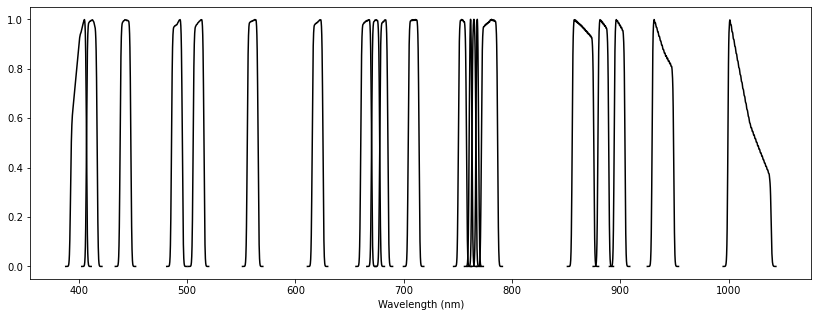

In [3]:
plt.figure(figsize=(14, 5))
for i in range(21):
    plt.plot(coastval_spectrum.data_sent_srf['MSRFwavelength'][:,i][:], 
             coastval_spectrum.data_sent_srf['MSRF'][:,i][:], c='k')
    plt.xlabel('Wavelength (nm)')

In [337]:
refs = ds_z.reflectivity.isel(z=slice(0, num_s3_pixels))
(refs.mean(dim='z') + 1.5*refs.std(dim='z')).values

array([0.0193375 , 0.02079844, 0.02570748, 0.03805291, 0.04095687,
       0.04528074, 0.0191685 , 0.01215039, 0.01142953, 0.01099925,
       0.00668802, 0.00262916, 0.00293577, 0.00155864, 0.00128208,
       0.00146127], dtype=float32)

In [323]:
pd.Series(coeff_of_variations)

0       0.09305385
1      0.022909094
2      0.043024108
3       0.03673396
4       0.23716919
5        0.4050524
6      0.046883985
7      0.027420525
8      0.008544109
9      0.014915806
10    0.0071050366
dtype: object

In [327]:
ds_z

<xarray.Dataset>
Dimensions:                  (band: 16, z: 150)
Coordinates:
    distance                 (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    lat                      (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    latitude                 (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    lon                      (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    longitude                (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    time                     datetime64[ns] 2019-09-21T10:51:11.640746
    wavelength               (band) float64 dask.array<chunksize=(16,), meta=np.ndarray>
    xx                       (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    yy                       (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
  * z                        (z) MultiIndex
  - x                        (z) int64 16 16 16 17 15 17 ... 11 11 11 11 11 11
  - y                        (z) int64 21 22 20 21 21 22 ... 26 16 27 15 28 14
Dimensions without coordinates: band
Data variables:
    altitude                 (z) float32 dask.array<chunksize=(150,), meta=np.ndarray>
    chl_nn                   (z) float32 dask.array<chunksize=(150,), meta=np.ndarray>
    chl_oc4me                (z) float32 dask.array<chunksize=(150,), meta=np.ndarray>
    iop_nn                   (z) float32 dask.array<chunksize=(150,), meta=np.ndarray>
    mask                     (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    reflectivity             (band, z) float32 dask.array<chunksize=(1, 150), meta=np.ndarray>
    reflectivity_err         (band, z) float32 dask.array<chunksize=(1, 150), meta=np.ndarray>
    reflectivity_satpy       (band, z) float32 dask.array<chunksize=(1, 150), meta=np.ndarray>
    satellite_azimuth_angle  (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    satellite_zenith_angle   (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    solar_azimuth_angle      (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    solar_zenith_angle       (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    trsp                     (z) float32 dask.array<chunksize=(150,), meta=np.ndarray>
    tsm_nn                   (z) float32 dask.array<chunksize=(150,), meta=np.ndarray>
    wqsf                     (z) float64 dask.array<chunksize=(150,), meta=np.ndarray>
Attributes:
    absolute_orbit_number:  18718
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2020-10-27T13:27:43Z
    history:                 
    institution:            MAR
    netCDF_version:         4.3.3.1 of Dec 10 2015 16:44:18 $
    product_name:           S3A_OL_2_WFR____20190921T105112_20190921T105412_2...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.00
    start_time:             2019-09-21T10:51:11.640746Z
    stop_time:              2019-09-21T10:54:11.640746Z
    title:                  OLCI Level 2 WATER Product, Reflectance Oa02 Data...

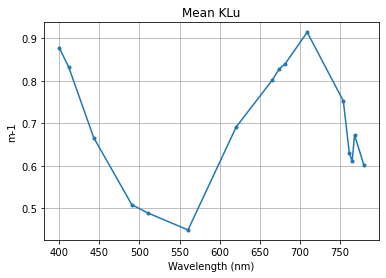

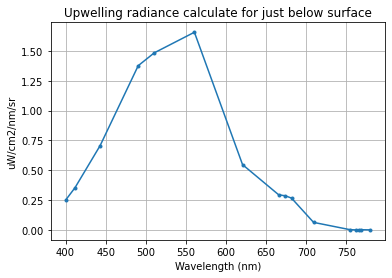

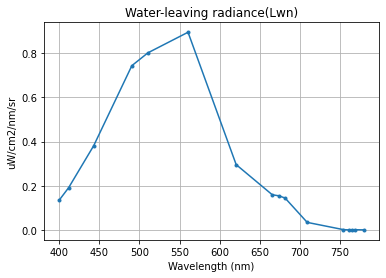

In [4]:
"""
Plots
"""

specs['KLus'].mean(axis=0).plot(marker='.')
plt.grid()
plt.title('Mean KLu')
plt.xlabel('Wavelength (nm)')
plt.ylabel('m-1')
plt.show()

specs['LunOminus'].mean().plot(marker='.')
plt.title('Upwelling radiance calculate for just below surface')
plt.xlabel('Wavelength (nm)')
plt.ylabel('uW/cm2/nm/sr')
plt.grid()
plt.show()

specs['Lwn'].mean().plot(marker='.')
plt.title('Water-leaving radiance(Lwn)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('uW/cm2/nm/sr')
plt.grid()
plt.show()

In [213]:
ds.

<xarray.DataArray 'x' (x: 10)>
array([16, 17, 15, 18, 14, 19, 12, 13, 20, 11])
Coordinates:
  * x        (x) int64 16 17 15 18 14 19 12 13 20 11

In [226]:
x0 = ds_z.x.isel(z=0).values
y0 = ds_z.y.isel(z=0).values

ds.sortby('x').sortby('y').sel(x=slice(x0 - 1, x0 + 1), y=slice(y0 - 1, y0 + 1))

<xarray.Dataset>
Dimensions:                  (band: 16, time: 1, x: 3, y: 3)
Coordinates:
    distance                 (x, y) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    lat                      (x, y) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    latitude                 (x, y) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    lon                      (x, y) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    longitude                (x, y) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2019-09-21T10:51:11.640746
    wavelength               (band) float64 dask.array<chunksize=(16,), meta=np.ndarray>
  * x                        (x) int64 15 16 17
    xx                       (x, y) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
  * y                        (y) int64 20 21 22
    yy                       (x, y) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
Dimensions without coordinates: band
Data variables:
    altitude                 (x, y) float32 dask.array<chunksize=(3, 3), meta=np.ndarray>
    chl_nn                   (time, x, y) float32 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    chl_oc4me                (time, x, y) float32 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    iop_nn                   (time, x, y) float32 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    mask                     (time, x, y) float64 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    reflectivity             (band, x, y) float32 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    reflectivity_err         (band, x, y) float32 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    reflectivity_satpy       (band, time, x, y) float32 dask.array<chunksize=(1, 1, 3, 3), meta=np.ndarray>
    satellite_azimuth_angle  (time, x, y) float64 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    satellite_zenith_angle   (time, x, y) float64 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    solar_azimuth_angle      (time, x, y) float64 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    solar_zenith_angle       (time, x, y) float64 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    trsp                     (time, x, y) float32 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    tsm_nn                   (time, x, y) float32 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    wqsf                     (time, x, y) float64 dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
Attributes:
    absolute_orbit_number:  18718
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2020-10-27T13:27:43Z
    history:                 
    institution:            MAR
    netCDF_version:         4.3.3.1 of Dec 10 2015 16:44:18 $
    product_name:           S3A_OL_2_WFR____20190921T105112_20190921T105412_2...
    references:             S3IPF PDS 004.3 - i2r3 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.00
    start_time:             2019-09-21T10:51:11.640746Z
    stop_time:              2019-09-21T10:54:11.640746Z
    title:                  OLCI Level 2 WATER Product, Reflectance Oa02 Data...

In [224]:
x0

array(16)

In [223]:
ds.x

<xarray.DataArray 'x' (x: 10)>
array([16, 17, 15, 18, 14, 19, 12, 13, 20, 11])
Coordinates:
  * x        (x) int64 16 17 15 18 14 19 12 13 20 11

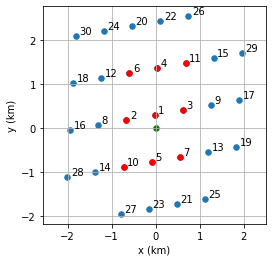

In [270]:
ds_t = ds_z.isel(z=slice(0, 30))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.axis('equal')

lon_cv, lat_cv = -6.07, 53.293
x_cv, y_cv = transform(4326, 32629, lon_cv, lat_cv)
ds_t['xx'] -= x_cv
ds_t['yy'] -= y_cv
ds_t['xx'] /= 1000
ds_t['yy'] /= 1000
colours = ['0.8' if i >= 9 else 'r' for i in range(len(ds_t.z))]
ax.scatter(ds_t.xx, ds_t.x.yy, s=30)
dd = ds.sortby('x').sortby('y').sel(x=slice(x0 - 1, x0 + 1), y=slice(y0 - 1, y0 + 1))
ax.scatter((dd.xx.values - x_cv)/1000, (dd.yy.values - y_cv)/1000, s=30, c='r')
for i, (x, y) in enumerate(zip(ds_t.xx, ds_t.x.yy)):
    ax.text(x + 80/1000, y + 40/1000, i + 1, fontsize=10)
ax.scatter(0, 0, s=30, c='g')
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.grid()

plt.savefig('/home/john/Downloads/s3_coastval_pixles.png', dpi=200)

<xarray.DataArray 'time' ()>
array('2019-09-21T10:51:11.640746000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-09-21T10:51:11.640746